In [1]:
from __future__ import absolute_import, print_function

# --- System ---
import os
import sys

# --- Utility ---
import pandas as pd
import numpy as np
import math
import random
import warnings
import datetime, time
warnings.filterwarnings('ignore')

# --- Plot --
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
dataPath = "data/statistics-5.csv"
df = pd.read_csv(dataPath)
# columnList = df.columns

# Dropping columns that are not required at the moment
df = df.drop(columns=[ 'Unnamed: 0', 'UUID', 'HOSTNAME', #'ALIAS',
                       'THROUGHPUT (Receiver)', 'LATENCY (min.)', 'LATENCY (max.)', 
                       'CONGESTION (Receiver)', 'BYTES (Receiver)'
                     ])

# Pre-processing
pacing = df['PACING'].values
for i, p in enumerate(pacing):
    v, _ = p.split("gbit")
    pacing[i] = float(v)

df['PACING'] = pacing
df['TYPE'] = (df['CONGESTION (Sender)'] == 'cubic').astype(int) # Cubic = 1 & BBRV2 = 0
df['TYPE-STREAM'] = df['CONGESTION (Sender)'].str[:] + "_" + df['STREAMS'].map(str)

In [3]:
unixtime = []
for i in range( len(df['TIMESTAMP']) ):
    
    unixtime.append(datetime.datetime.strptime(df['TIMESTAMP'][i], '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())

df['UNIX'] = unixtime
df.head(5)

,ALIAS,TIMESTAMP,STREAMS,PACING,THROUGHPUT (Sender),LATENCY (mean),RETRANSMITS,CONGESTION (Sender),TYPE,TYPE-STREAM,UNIX
0,hostA,2021-06-28T18:53:00.826Z,1,1.0,1.623277e+09,30185.5,1535.0,cubic,1,cubic_1,1.624921e+09
1,hostA,2021-06-28T18:54:13.558Z,1,1.0,1.652145e+09,60378.5,2879.0,cubic,1,cubic_1,1.624921e+09
2,hostA,2021-06-28T20:30:47.452Z,1,1.0,9.833584e+08,91801.0,2879.0,cubic,1,cubic_1,1.624927e+09
3,hostA,2021-06-28T20:32:00.530Z,1,2.0,1.965511e+09,123221.5,2879.0,cubic,1,cubic_1,1.624927e+09
4,hostA,2021-06-28T20:33:13.592Z,1,3.0,2.946649e+09,154710.5,2879.0,cubic,1,cubic_1,1.624927e+09


In [4]:
joblist = df['TYPE-STREAM'].unique()
hostlist = df['ALIAS'].unique()
pacingList = df['PACING'].unique()

print("Job list: ", joblist)
print("Host list: ", hostlist)
print("Pacing list: ", pacingList)

Job list:  ['cubic_1' 'cubic_4' 'bbr2_1' 'bbr2_4' 'cubic_8' 'cubic_16' 'bbr2_8'
 'bbr2_16']
Host list:  ['hostA' 'hostB' 'hostC' 'testW' 'hostE' 'hostD' 'WANb' 'WANa' 'WANc']
Pacing list:  [1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 0.5 1.5 2.4 3.5 4.5 5.5 6.5 7.5
 8.5 9.5 10.5]


## All the values

In [5]:
# for host in hostlist:

#     print("Plotting for ", str(host))
#     cubic, bbrv2 = [], []

#     for p in pacingList: # range(1, 11):
#         cubic.append( df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']==host) & (df['PACING']==p) ] )
#         bbrv2.append( df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') )  & (df['ALIAS']==host) & (df['PACING']==p) ] )

#     fig, axs = plt.subplots(2, 5, figsize = (28,8), constrained_layout=True)

#     for ax, idx in zip(axs.flat, range(0, 10)):
#         ax.plot (cubic[idx]['TYPE-STREAM'], cubic[idx]['THROUGHPUT (Sender)'], 'o-', color='blue', label='cubic')
#         ax.plot (bbrv2[idx]['TYPE-STREAM'], bbrv2[idx]['THROUGHPUT (Sender)'], 'o-', color='green', label='bbrv2')
#         ax.set_title(str(host)+", Pacing "+str(idx+1))
#         ax.set(xlabel='congestion type', ylabel='throughput')
#         ax.grid(True)
#         ax.legend()
#     plt.savefig("plots/"+str(host)+".png", dpi=200)
#     plt.show()

## Only Max Values

Plotting for  hostA


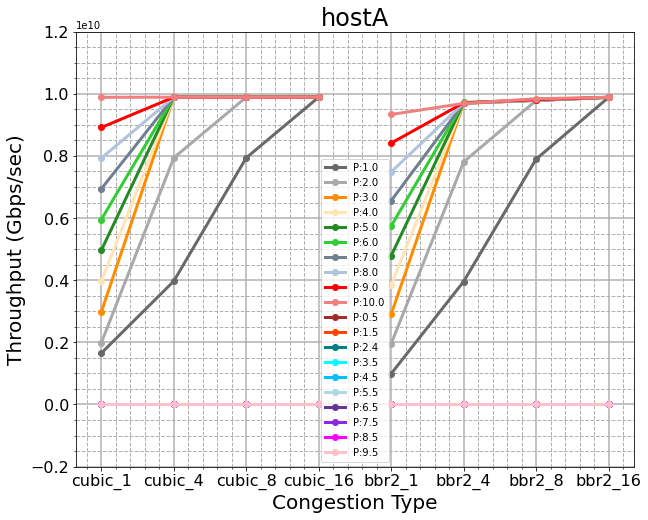

Plotting for  hostB


In [23]:
colorList = ['dimgray','darkgray', 'darkorange','moccasin', 'forestgreen','limegreen', 'slategrey','lightsteelblue', 'red','lightcoral', 
            'brown','orangered', 'teal','aqua', 'deepskyblue','lightblue', 'rebeccapurple','blueviolet', 'fuchsia','pink']

for host in hostlist:
    if host!="testW":
        print("Plotting for ", str(host))

        cubic, bbrv2 = [], []
        cubic_types = ['cubic_1', 'cubic_4', 'cubic_8', 'cubic_16']
        bbr2_types = ['bbr2_1', 'bbr2_4', 'bbr2_8', 'bbr2_16']

        for p in pacingList:
            cubic_1  = df.loc[ ( df['TYPE-STREAM']=='cubic_1')  & (df['ALIAS']==host) & (df['PACING']==p) ]
            cubic_4  = df.loc[ ( df['TYPE-STREAM']=='cubic_4')  & (df['ALIAS']==host) & (df['PACING']==p) ]
            cubic_8  = df.loc[ ( df['TYPE-STREAM']=='cubic_8')  & (df['ALIAS']==host) & (df['PACING']==p) ]
            cubic_16 = df.loc[ ( df['TYPE-STREAM']=='cubic_16') & (df['ALIAS']==host) & (df['PACING']==p) ]
            
            try:
                tput_cubic = [ max(cubic_1['THROUGHPUT (Sender)']), max(cubic_4['THROUGHPUT (Sender)']), max(cubic_8['THROUGHPUT (Sender)']), max(cubic_16['THROUGHPUT (Sender)'])]    
            except Exception as e:
                tput_cubic = [0, 0, 0, 0]
                # print(e)
            cubic.append(tput_cubic)

            bbr_1  = df.loc[ ( df['TYPE-STREAM']=='bbr2_1')  & (df['ALIAS']==host) & (df['PACING']==p) ]
            bbr_4  = df.loc[ ( df['TYPE-STREAM']=='bbr2_4')  & (df['ALIAS']==host) & (df['PACING']==p) ]
            bbr_8  = df.loc[ ( df['TYPE-STREAM']=='bbr2_8')  & (df['ALIAS']==host) & (df['PACING']==p) ]
            bbr_16 = df.loc[ ( df['TYPE-STREAM']=='bbr2_16') & (df['ALIAS']==host) & (df['PACING']==p) ]

            try:
                tput_bbr = [ max(bbr_1['THROUGHPUT (Sender)']), max(bbr_4['THROUGHPUT (Sender)']), max(bbr_8['THROUGHPUT (Sender)']), max(bbr_16['THROUGHPUT (Sender)'])]
            except Exception as e:
                tput_bbr = [0, 0, 0, 0]
                # print(e)
            bbrv2.append(tput_bbr)

        fig = plt.figure(figsize=(10, 8)) # (17, 11))

        plt.title (str(host), fontsize=24)
        for idx, p, cL in zip(range(len(cubic)), pacingList, colorList):
            plt.plot (cubic_types, cubic[idx], 'o-', c=cL, linewidth=3)
            plt.plot (bbr2_types, bbrv2[idx],  'o-', c=cL, linewidth=3, label='P:'+str(p))
        
        axes = plt.gca()
        
        plt.xlabel('Congestion Type', fontsize=20)
        plt.xticks(fontsize=16)

        axes.set_ylim([-0.2e10,1.2e10])
        plt.yticks(fontsize=16)
        plt.ylabel('Throughput (Gbps/sec)', fontsize=20)
        
        plt.minorticks_on()
        plt.grid (b=True, which='major', linestyle='-', linewidth=1.5)
        plt.grid (b=True, which='minor', linestyle='--', linewidth=1)
        plt.legend (loc=0)#, fontsize=12)
        plt.savefig("plots/max/"+str(host)+"(max_).png", dpi=100)
        plt.show()

In [ ]:
# for host in hostlist:

#     print("Plotting for ", str(host))

#     cubic, bbrv2 = [], []
#     cubic_types = ['cubic_1', 'cubic_4', 'cubic_8', 'cubic_16']
#     bbr2_types = ['bbr2_1', 'bbr2_4', 'bbr2_8', 'bbr2_16']

#     for p in pacingList: # range(1,11):
#         cubic_1  = df.loc[ ( df['TYPE-STREAM']=='cubic_1')  & (df['ALIAS']==host) & (df['PACING']==p) ]
#         cubic_4  = df.loc[ ( df['TYPE-STREAM']=='cubic_4')  & (df['ALIAS']==host) & (df['PACING']==p) ]
#         cubic_8  = df.loc[ ( df['TYPE-STREAM']=='cubic_8')  & (df['ALIAS']==host) & (df['PACING']==p) ]
#         cubic_16 = df.loc[ ( df['TYPE-STREAM']=='cubic_16') & (df['ALIAS']==host) & (df['PACING']==p) ]
        
#         try:
#             tput_cubic = [ max(cubic_1['THROUGHPUT (Sender)']), max(cubic_4['THROUGHPUT (Sender)']), max(cubic_8['THROUGHPUT (Sender)']), max(cubic_16['THROUGHPUT (Sender)'])]    
#         except Exception as e:
#             tput_cubic = [0, 0, 0, 0]
#             print(e)
#         cubic.append(tput_cubic)

#         bbr_1  = df.loc[ ( df['TYPE-STREAM']=='bbr2_1')  & (df['ALIAS']==host) & (df['PACING']==p) ]
#         bbr_4  = df.loc[ ( df['TYPE-STREAM']=='bbr2_4')  & (df['ALIAS']==host) & (df['PACING']==p) ]
#         bbr_8  = df.loc[ ( df['TYPE-STREAM']=='bbr2_8')  & (df['ALIAS']==host) & (df['PACING']==p) ]
#         bbr_16 = df.loc[ ( df['TYPE-STREAM']=='bbr2_16') & (df['ALIAS']==host) & (df['PACING']==p) ]

#         try:
#             tput_bbr = [ max(bbr_1['THROUGHPUT (Sender)']), max(bbr_4['THROUGHPUT (Sender)']), max(bbr_8['THROUGHPUT (Sender)']), max(bbr_16['THROUGHPUT (Sender)'])]
#         except Exception as e:
#             tput_bbr = [0, 0, 0, 0]
#             print(e)
#         bbrv2.append(tput_bbr)

#     fig, axs = plt.subplots(2, 5, figsize = (25,6), constrained_layout=True)#, sharey='row')
#     for ax, idx in zip(axs.flat, range(0, 10)):
#         ax.plot (cubic_types, cubic[idx], 'o-', color='blue', label='cubic')
#         ax.plot (bbr2_types,  bbrv2[idx], 'o--', color='green', label='bbrv2')
        
#         ax.set_title(str(host)+", Pacing "+str(idx+1))
#         ax.set(xlabel='congestion type (type+stream)', ylabel='throughput (Gbps/sec)')

#         ax.grid(True)
#         ax.legend()
        
#     # plt.savefig("plots/"+str(host)+"(max).png", dpi=150)
#     plt.show()

In [ ]:
# # PACING 1
# p=1
# tput_cubic_p1  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p1  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# # PACING 2
# p=2
# tput_cubic_p2  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p2  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=3
# tput_cubic_p3  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p3  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=4
# tput_cubic_p4  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p4  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=5
# tput_cubic_p5  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p5  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=6
# tput_cubic_p6  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p6  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=7
# tput_cubic_p7  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p7  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=8
# tput_cubic_p8  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p8  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=9
# tput_cubic_p9  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p9  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# # PACING 2
# p=10
# tput_cubic_p10  = df.loc[ ( df['TYPE-STREAM'].str.startswith('cubic') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]
# tput_bbrv2_p10  = df.loc[ ( df['TYPE-STREAM'].str.startswith('bbr2') ) & (df['ALIAS']=='hostA') & (df['PACING']==p) ]

# cubic = [tput_cubic_p1,tput_cubic_p2,tput_cubic_p3,tput_cubic_p4,tput_cubic_p5,tput_cubic_p6,tput_cubic_p7,tput_cubic_p8,tput_cubic_p9,tput_cubic_p10]
# bbrv2 = [tput_bbrv2_p1,tput_bbrv2_p2,tput_bbrv2_p3,tput_bbrv2_p4,tput_bbrv2_p5,tput_bbrv2_p6,tput_bbrv2_p7,tput_bbrv2_p8,tput_bbrv2_p9,tput_bbrv2_p10]

# plt.figure(figsize = (18,7))

# plt.plot (cubic[0]['TYPE-STREAM'], cubic[0]['THROUGHPUT (Sender)'], 'o-', label="hostA, Pacing 1")

# plt.xlabel('Congestion Type', fontsize=16)
# plt.ylabel('Throughput',fontsize=16)

# plt.legend(fontsize=10)
# plt.grid(True)cubicp1.png", dpi=150)

# plt.show()

In [ ]:
# fig, axs = plt.subplots(6, 4, figsize = (20,16), constrained_layout=True)

# axs[0, 0].plot (cubic[0]['TYPE-STREAM'], cubic[0]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 0].set_title("hostA, Pacing 1")

# axs[0, 1].plot (bbrv2[0]['TYPE-STREAM'], bbrv2[0]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 1].set_title('hostA, Pacing 1')

# axs[0, 2].plot (cubic[1]['TYPE-STREAM'], cubic[1]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 2].set_title('hostA, Pacing 2')

# axs[0, 3].plot (bbrv2[1]['TYPE-STREAM'], bbrv2[1]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 3].set_title('hostA, Pacing 2')

# #------

# axs[1, 0].plot (cubic[2]['TYPE-STREAM'], cubic[2]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 0].set_title('hostA, Pacing 3')

# axs[1, 1].plot (bbrv2[2]['TYPE-STREAM'], bbrv2[2]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 1].set_title('hostA, Pacing 3')

# axs[1, 2].plot (cubic[3]['TYPE-STREAM'], cubic[3]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 2].set_title('hostA, Pacing 4')

# axs[1, 3].plot (bbrv2[3]['TYPE-STREAM'], bbrv2[3]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 3].set_title('hostA, Pacing 4')

# #------

# axs[2, 0].plot (cubic[4]['TYPE-STREAM'], cubic[4]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[2, 0].set_title('hostA, Pacing 5')

# axs[2, 1].plot (bbrv2[4]['TYPE-STREAM'], bbrv2[4]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[2, 1].set_title('hostA, Pacing 5')

# axs[3, 2].plot (cubic[5]['TYPE-STREAM'], cubic[5]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[3, 2].set_title('hostA, Pacing 6')

# axs[3, 3].plot (bbrv2[5]['TYPE-STREAM'], bbrv2[5]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[3, 3].set_title('hostA, Pacing 6')

# #------

# axs[4, 0].plot (cubic[6]['TYPE-STREAM'], cubic[6]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[4, 0].set_title('hostA, Pacing 7')

# axs[4, 1].plot (bbrv2[6]['TYPE-STREAM'], bbrv2[6]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[4, 1].set_title('hostA, Pacing 7')

# axs[4, 2].plot (cubic[7]['TYPE-STREAM'], cubic[7]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[4, 2].set_title('hostA, Pacing 8')

# axs[4, 3].plot (bbrv2[7]['TYPE-STREAM'], bbrv2[7]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[4, 3].set_title('hostA, Pacing 8')

# #------

# axs[5, 0].plot (cubic[8]['TYPE-STREAM'], cubic[8]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[5, 0].set_title('hostA, Pacing 9')

# axs[5, 1].plot (bbrv2[8]['TYPE-STREAM'], bbrv2[8]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[5, 1].set_title('hostA, Pacing 9')

# axs[5, 2].plot (cubic[9]['TYPE-STREAM'], cubic[9]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[5, 2].set_title('hostA, Pacing 10')

# axs[5, 3].plot (bbrv2[9]['TYPE-STREAM'], bbrv2[9]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[5, 3].set_title('hostA, Pacing 10')

# #------


# for ax in axs.flat:
#     ax.set(xlabel='congestion type', ylabel='throughput')

# # # Hide x labels and tick labels for top plots and y ticks for right plots.
# # for ax in axs.flat:
# #     ax.label_inner()

In [ ]:
# axs[0, 0].plot (cubic[0]['TYPE-STREAM'], cubic[0]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 0].plot (bbrv2[0]['TYPE-STREAM'], bbrv2[0]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 0].set_title("hostA, Pacing 1")

# axs[0, 1].plot (cubic[1]['TYPE-STREAM'], cubic[1]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 1].plot (bbrv2[1]['TYPE-STREAM'], bbrv2[1]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 1].set_title('hostA, Pacing 2')

# axs[0, 2].plot (cubic[2]['TYPE-STREAM'], cubic[2]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 2].plot (bbrv2[2]['TYPE-STREAM'], bbrv2[2]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 2].set_title('hostA, Pacing 3')

# axs[0, 3].plot (cubic[3]['TYPE-STREAM'], cubic[3]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 3].plot (bbrv2[3]['TYPE-STREAM'], bbrv2[3]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 3].set_title('hostA, Pacing 4')

# axs[0, 4].plot (cubic[4]['TYPE-STREAM'], cubic[4]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[0, 4].plot (bbrv2[4]['TYPE-STREAM'], bbrv2[4]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[0, 4].set_title('hostA, Pacing 5')

# axs[1, 0].plot (cubic[5]['TYPE-STREAM'], cubic[5]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 0].plot (bbrv2[5]['TYPE-STREAM'], bbrv2[5]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 0].set_title('hostA, Pacing 6')

# axs[1, 1].plot (cubic[6]['TYPE-STREAM'], cubic[6]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 1].plot (bbrv2[6]['TYPE-STREAM'], bbrv2[6]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 1].set_title('hostA, Pacing 7')

# axs[1, 2].plot (cubic[7]['TYPE-STREAM'], cubic[7]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 2].plot (bbrv2[7]['TYPE-STREAM'], bbrv2[7]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 2].set_title('hostA, Pacing 8')

# axs[1, 3].plot (cubic[8]['TYPE-STREAM'], cubic[8]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 3].plot (bbrv2[8]['TYPE-STREAM'], bbrv2[8]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 3].set_title('hostA, Pacing 9')

# axs[1, 4].plot (cubic[9]['TYPE-STREAM'], cubic[9]['THROUGHPUT (Sender)'], 'o-', color='blue')
# axs[1, 4].plot (bbrv2[9]['TYPE-STREAM'], bbrv2[9]['THROUGHPUT (Sender)'], 'o-', color='green')
# axs[1, 4].set_title('hostA, Pacing 10')

# for ax in axs.flat:
#     ax.set(xlabel='congestion type', ylabel='throughput')
#     ax.grid(True)

In [ ]:
# # a = len(df['THROUGHPUT (Sender)'])
# # throughput_s1_cubic = df['THROUGHPUT (Sender)'][df['STREAMS']==1][df['CONGESTION (Sender)']]
# # throughput_s4_cubic = df['THROUGHPUT (Sender)'][df['STREAMS']==4][df['CONGESTION (Sender)']]

# # =========
# # PACING 1
# # =========
# p=1
# throughput_s1_cubic_p1 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p1 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p1 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p1 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]

# # =========
# # PACING 2
# # =========
# p=2
# throughput_s1_cubic_p2 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p2 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p2 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p2 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]

# # =========
# # PACING 3
# # =========
# p=3
# throughput_s1_cubic_p3 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p3 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p3 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p3 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]


# # =========
# # PACING 4
# # =========
# p=4
# throughput_s1_cubic_p4 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p4 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p4 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p4 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]


# # =========
# # PACING 5
# # =========
# p=5
# throughput_s1_cubic_p5 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p5 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p5 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p5 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]


# # =========
# # PACING 6
# # =========
# p=6
# throughput_s1_cubic_p6 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p6 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p6 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p6 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]

# # =========
# # PACING 7
# # =========
# p=7
# throughput_s1_cubic_p7 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p7 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p7 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p7 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]


# # =========
# # PACING 8
# # =========
# p=8
# throughput_s1_cubic_p8 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p8 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p8 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p8 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]

# # =========
# # PACING 9
# # =========
# p=9
# throughput_s1_cubic_p9 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p9 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p9 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p9 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]

# # =========
# # PACING 10
# # =========
# p=10
# throughput_s1_cubic_p10 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==1) & (df['PACING']==p) ]
# throughput_s4_cubic_p10 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==1) & (df['PACING']==p) ]

# throughput_s1_bbrv2_p10 = df.loc[ (df['STREAMS']==1) & (df['TYPE']==0) & (df['PACING']==p) ]
# throughput_s4_bbrv2_p10 = df.loc[ (df['STREAMS']==4) & (df['TYPE']==0) & (df['PACING']==p) ]


In [ ]:
# plt.figure(figsize = (18,7))

# plt.plot(throughput_s1_cubic_p1['PACING'], throughput_s1_cubic_p1['THROUGHPUT (Sender)'], label="Cubic, S:1, P:1")#, linestyle='-')
# plt.plot(throughput_s4_cubic_p1['PACING'], throughput_s4_cubic_p1['THROUGHPUT (Sender)'], label="Cubic, S:4, P:1")#, linestyle='-')
# plt.plot(throughput_s1_bbrv2_p1['PACING'], throughput_s1_bbrv2_p1['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:1")#, linestyle='-')
# plt.plot(throughput_s4_bbrv2_p1['PACING'], throughput_s4_bbrv2_p1['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:1")#, linestyle='-')

# plt.plot(throughput_s1_cubic_p2['PACING'], throughput_s1_cubic_p2['THROUGHPUT (Sender)'], label="Cubic, S:1, P:2")
# plt.plot(throughput_s4_cubic_p2['PACING'], throughput_s4_cubic_p2['THROUGHPUT (Sender)'], label="Cubic, S:4, P:2")
# plt.plot(throughput_s1_bbrv2_p2['PACING'], throughput_s1_bbrv2_p2['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:2")
# plt.plot(throughput_s4_bbrv2_p2['PACING'], throughput_s4_bbrv2_p2['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:2")

# plt.plot(throughput_s1_cubic_p3['PACING'], throughput_s1_cubic_p3['THROUGHPUT (Sender)'], label="Cubic, S:1, P:3")
# plt.plot(throughput_s4_cubic_p3['PACING'], throughput_s4_cubic_p3['THROUGHPUT (Sender)'], label="Cubic, S:4, P:3")
# plt.plot(throughput_s1_bbrv2_p3['PACING'], throughput_s1_bbrv2_p3['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:3")
# plt.plot(throughput_s4_bbrv2_p3['PACING'], throughput_s4_bbrv2_p3['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:3")

# plt.plot(throughput_s1_cubic_p4['PACING'], throughput_s1_cubic_p4['THROUGHPUT (Sender)'], label="Cubic, S:1, P:4")
# plt.plot(throughput_s4_cubic_p4['PACING'], throughput_s4_cubic_p4['THROUGHPUT (Sender)'], label="Cubic, S:4, P:4")
# plt.plot(throughput_s1_bbrv2_p4['PACING'], throughput_s1_bbrv2_p4['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:4")
# plt.plot(throughput_s4_bbrv2_p4['PACING'], throughput_s4_bbrv2_p4['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:4")

# plt.plot(throughput_s1_cubic_p5['PACING'], throughput_s1_cubic_p5['THROUGHPUT (Sender)'], label="Cubic, S:1, P:5")
# plt.plot(throughput_s4_cubic_p5['PACING'], throughput_s4_cubic_p5['THROUGHPUT (Sender)'], label="Cubic, S:4, P:5")
# plt.plot(throughput_s1_bbrv2_p5['PACING'], throughput_s1_bbrv2_p5['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:5")
# plt.plot(throughput_s4_bbrv2_p5['PACING'], throughput_s4_bbrv2_p5['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:5")

# plt.plot(throughput_s1_cubic_p6['PACING'], throughput_s1_cubic_p6['THROUGHPUT (Sender)'], label="Cubic, S:1, P:6")
# plt.plot(throughput_s4_cubic_p6['PACING'], throughput_s4_cubic_p6['THROUGHPUT (Sender)'], label="Cubic, S:4, P:6")
# plt.plot(throughput_s1_bbrv2_p6['PACING'], throughput_s1_bbrv2_p6['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:6")
# plt.plot(throughput_s4_bbrv2_p6['PACING'], throughput_s4_bbrv2_p6['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:6")

# plt.plot(throughput_s1_cubic_p7['PACING'], throughput_s1_cubic_p7['THROUGHPUT (Sender)'], label="Cubic, S:1, P:7")
# plt.plot(throughput_s4_cubic_p7['PACING'], throughput_s4_cubic_p7['THROUGHPUT (Sender)'], label="Cubic, S:4, P:7")
# plt.plot(throughput_s1_bbrv2_p7['PACING'], throughput_s1_bbrv2_p7['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:7")
# plt.plot(throughput_s4_bbrv2_p7['PACING'], throughput_s4_bbrv2_p7['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:7")

# plt.plot(throughput_s1_cubic_p8['PACING'], throughput_s1_cubic_p8['THROUGHPUT (Sender)'], label="Cubic, S:1, P:8")
# plt.plot(throughput_s4_cubic_p8['PACING'], throughput_s4_cubic_p8['THROUGHPUT (Sender)'], label="Cubic, S:4, P:8")
# plt.plot(throughput_s1_bbrv2_p8['PACING'], throughput_s1_bbrv2_p8['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:8")
# plt.plot(throughput_s4_bbrv2_p8['PACING'], throughput_s4_bbrv2_p8['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:8")

# plt.plot(throughput_s1_cubic_p9['PACING'], throughput_s1_cubic_p9['THROUGHPUT (Sender)'], label="Cubic, S:1, P:9")
# plt.plot(throughput_s4_cubic_p9['PACING'], throughput_s4_cubic_p9['THROUGHPUT (Sender)'], label="Cubic, S:4, P:9")
# plt.plot(throughput_s1_bbrv2_p9['PACING'], throughput_s1_bbrv2_p9['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:9")
# plt.plot(throughput_s4_bbrv2_p9['PACING'], throughput_s4_bbrv2_p9['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:9")

# plt.plot(throughput_s1_cubic_p10['PACING'], throughput_s1_cubic_p10['THROUGHPUT (Sender)'], label="Cubic, S:1, P:10")
# plt.plot(throughput_s4_cubic_p10['PACING'], throughput_s4_cubic_p10['THROUGHPUT (Sender)'], label="Cubic, S:4, P:10")
# plt.plot(throughput_s1_bbrv2_p10['PACING'], throughput_s1_bbrv2_p10['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:10")
# plt.plot(throughput_s4_bbrv2_p10['PACING'], throughput_s4_bbrv2_p10['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:10")

# # plt.gcf().autofmt_xdate()

# plt.title("Throughtput with Congestion type: {Cubic, BBRV2} | Streams: {1,4} | Pacing rate: {1..10}", fontsize=20)
# plt.xlabel('Relative Unix Time (secs)', fontsize=16)
# plt.ylabel('Throughput',fontsize=16) 

# plt.legend(fontsize=5)
# plt.grid(True)

# # SPACE B/W PLOTS
# plt.tight_layout(4)

# # SAVE FIG
# # plt.savefig("plots/throughput-cubic-p1.png", dpi=150)

# plt.show()

In [ ]:
# plt.figure(figsize = (18,7))

# throughput_s1_cubic_p1_t, throughput_s1_cubic_p1_tput = list(throughput_s1_cubic_p1['TIMESTAMP']), list(throughput_s1_cubic_p1['THROUGHPUT (Sender)'])
# throughput_s4_cubic_p1_t, throughput_s4_cubic_p1_tput = list(throughput_s4_cubic_p1['TIMESTAMP']), list(throughput_s4_cubic_p1['THROUGHPUT (Sender)'])
# throughput_s1_bbrv2_p1_t, throughput_s1_bbrv2_p1_tput = list(throughput_s1_bbrv2_p1['TIMESTAMP']), list(throughput_s1_bbrv2_p1['THROUGHPUT (Sender)'])
# throughput_s4_bbrv2_p1_t, throughput_s4_bbrv2_p1_tput = list(throughput_s4_bbrv2_p1['TIMESTAMP']), list(throughput_s4_bbrv2_p1['THROUGHPUT (Sender)'])

# plt.plot(throughput_s1_cubic_p1['TIMESTAMP'], throughput_s1_cubic_p1['THROUGHPUT (Sender)'], label="Cubic, S:1, P:1")#, linestyle='-')
# plt.plot(throughput_s4_cubic_p1['TIMESTAMP'], throughput_s4_cubic_p1['THROUGHPUT (Sender)'], label="Cubic, S:4, P:1")#, linestyle='-')
# plt.plot(throughput_s1_bbrv2_p1['TIMESTAMP'], throughput_s1_bbrv2_p1['THROUGHPUT (Sender)'], label="bbrv2, S:1, P:1")#, linestyle='-')
# plt.plot(throughput_s4_bbrv2_p1['TIMESTAMP'], throughput_s4_bbrv2_p1['THROUGHPUT (Sender)'], label="bbrv2, S:4, P:1")#, linestyle='-')
# plt.gcf().autofmt_xdate()

# plt.title("Throughtput with Congestion type: {Cubic, BBRV2} | Streams: {1,4} | Pacing rate: {1..10}", fontsize=22)
# plt.xlabel('Timestamp', fontsize=18)
# plt.ylabel('Throughput',fontsize=18) 

# plt.legend(fontsize=5)
# plt.grid(True)

# # SPACE B/W PLOTS
# plt.tight_layout(4)

# # SAVE FIG
# # plt.savefig("plots/throughput-cubic-p1.png", dpi=150)

# plt.show()